In [261]:
import numpy as np
import pandas as pd
from datetime import datetime
import calendar
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [262]:
train = train[train['weather'] != 4]

In [263]:
all_data = pd.concat([train, test], ignore_index=True)

In [264]:
all_data.drop(['season', 'workingday'], axis=1, inplace=True)


In [265]:
all_data['tempDate'] = all_data.datetime.apply(lambda x:x.split())

all_data['year'] = all_data['tempDate'].apply(lambda x: x[0].split('-')[0])
all_data['month'] = all_data['tempDate'].apply(lambda x: x[0].split('-')[1])
all_data['hour'] = all_data['tempDate'].apply(lambda x: x[1].split(':')[0])
all_data['weekday'] = all_data.tempDate.apply(lambda x:calendar.day_name[datetime.strptime(x[0], "%Y-%m-%d").weekday()])

all_data = all_data.drop('tempDate', axis=1)
all_data = all_data.drop('datetime', axis=1)
all_data.head()


holiday  weather  temp   atemp  humidity  windspeed  casual  registered  \
0        0        1  9.84  14.395        81        0.0     3.0        13.0   
1        0        1  9.02  13.635        80        0.0     8.0        32.0   
2        0        1  9.02  13.635        80        0.0     5.0        27.0   
3        0        1  9.84  14.395        75        0.0     3.0        10.0   
4        0        1  9.84  14.395        75        0.0     0.0         1.0   

   count  year month hour   weekday  
0   16.0  2011    01   00  Saturday  
1   40.0  2011    01   01  Saturday  
2   32.0  2011    01   02  Saturday  
3   13.0  2011    01   03  Saturday  
4    1.0  2011    01   04  Saturday

In [266]:
# atemp
def predict_atemp(data):
    validData = data[(data["atemp"] > 15) | (data["temp"] <= 20)]
    invalidData = data[(data["atemp"] <= 15) & (data["temp"] > 20)]

    lin_atemp = LinearRegression()
    lin_atemp.fit(validData[["temp"]], validData[["atemp"]])

    predict_atemp = lin_atemp.predict(invalidData[["temp"]])
    
    invalidData.loc[:, "atemp"] = predict_atemp

    data = pd.concat([validData, invalidData], ignore_index=True)

    return data

In [267]:
all_data = predict_atemp(all_data)

In [268]:
# windspeed
from sklearn.ensemble import RandomForestClassifier

data = all_data
trainWind0 = data.loc[data["windspeed"] == 0]
trainWindNot0 = data.loc[data["windspeed"]!=0]

def predict_windspeed(data):
    dataWind0 = data.loc[data["windspeed"] == 0]
    dataWindNot0 = data.loc[data["windspeed"] != 0]

    windColumns = ["weather", "humidity", "month", "temp", "atemp"]
    dataWindNot0.loc[:, "windspeed"] = dataWindNot0["windspeed"].astype("str")

    rf_wind = RandomForestRegressor()
    rf_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])
    wind0 = rf_wind.predict(X=dataWind0[windColumns])
    
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    predictWind0.loc[:, "windspeed"] = wind0

    data = pd.concat([predictWindNot0, predictWind0], ignore_index=True)
    data["windspeed"] = data["windspeed"].astype("float")
    
    return data

In [269]:
all_data = predict_windspeed(all_data)

In [270]:
# humidity
def predict_humidity(data):
    dataHum0 = data[data["humidity"]==0]
    dataHumNot0 = data[data["humidity"]!=0]

    humidityColumns = ["weather", "windspeed", "month", "temp", "atemp"]

    rf_humidity = RandomForestRegressor()
    rf_humidity.fit(dataHumNot0[humidityColumns], dataHumNot0["humidity"])

    predictHumidity0 = rf_humidity.predict(X= dataHum0[humidityColumns])
    dataHum0.loc[:, "humidity"] = predictHumidity0

    data = pd.concat([dataHumNot0, dataHum0], ignore_index=True)
    # data.reset_index(inplace = True)
    # data.drop("index", inplace = True, axis = 1)

    return data


In [271]:
all_data = predict_humidity(all_data)

In [272]:
oheFeatures = ["holiday", "weather", "weekday", "month", "year", "hour"]
all_data = pd.get_dummies(all_data, columns=oheFeatures)
all_data.head()

temp   atemp  humidity  windspeed  casual  registered  count  holiday_0  \
0   9.84  12.880      75.0     6.0032     0.0         1.0    1.0       True   
1  15.58  19.695      76.0    16.9979    12.0        24.0   36.0       True   
2  14.76  16.665      81.0    19.0012    26.0        30.0   56.0       True   
3  17.22  21.210      77.0    19.0012    29.0        55.0   84.0       True   
4  18.86  22.725      72.0    19.9995    47.0        47.0   94.0       True   

   holiday_1  weather_1  ...  hour_14  hour_15  hour_16  hour_17  hour_18  \
0      False      False  ...    False    False    False    False    False   
1      False       True  ...    False    False    False    False    False   
2      False       True  ...    False    False    False    False    False   
3      False       True  ...    False    False    False    False    False   
4      False      False  ...    False    False    False    False    False   

   hour_19  hour_20  hour_21  hour_22  hour_23  
0    False    False    False    False    False  
1    False    False    False    False    False  
2    False    False    False    False    False  
3    False    False    False    False    False  
4    False    False    False    False    False  

[5 rows x 58 columns]

In [282]:
train = all_data[:train.shape[0]]
test = all_data[train.shape[0]:]

In [284]:
# target = train['log_count']
target = train['count']

<Axes: xlabel='humidity', ylabel='count'>

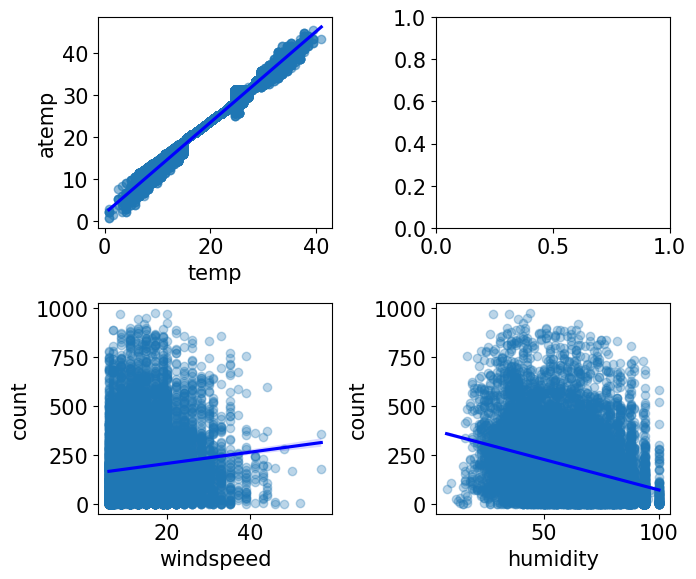

In [274]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rc('font', size = 15)
figure, axes = plt.subplots(nrows = 2, ncols = 2)
plt.tight_layout()
figure.set_size_inches(7,6)

sns.regplot(x = 'temp', y = 'atemp', data = train, ax = axes[0,0], scatter_kws= {'alpha': 0.5}, line_kws={'color': 'blue'})
sns.regplot(x = 'windspeed', y = 'count', data = train, ax = axes[1,0], scatter_kws= {'alpha': 0.3}, line_kws={'color': 'blue'})
sns.regplot(x = 'humidity', y = 'count', data = train, ax = axes[1,1], scatter_kws= {'alpha': 0.3}, line_kws={'color': 'blue'})

In [285]:
import numpy as np
def rmsle_score(pred, real):
    return(np.sum((np.log1p(pred) - np.log1p(real))**2)/len(real)**.5)

In [286]:
from sklearn.metrics import make_scorer
RMSLE = make_scorer(rmsle_score)

In [289]:
from sklearn.model_selection import train_test_split 

X_train, X_validation, y_train, y_validation = train_test_split(train, target, test_size=0.2, shuffle=True)

In [290]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

param_Rf =  {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
RF = make_pipeline(GridSearchCV(RandomForestRegressor(random_state=1), param_Rf, cv=10, scoring = RMSLE))
RF.fit(X_train,y_train)

ValueError: 
All the 80 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/phs/playground/kg-bike-sharing-demand/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/phs/playground/kg-bike-sharing-demand/venv/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/phs/playground/kg-bike-sharing-demand/venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 348, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/phs/playground/kg-bike-sharing-demand/venv/lib/python3.11/site-packages/sklearn/base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/phs/playground/kg-bike-sharing-demand/venv/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1146, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/phs/playground/kg-bike-sharing-demand/venv/lib/python3.11/site-packages/sklearn/utils/validation.py", line 957, in check_array
    _assert_all_finite(
  File "/Users/phs/playground/kg-bike-sharing-demand/venv/lib/python3.11/site-packages/sklearn/utils/validation.py", line 122, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/phs/playground/kg-bike-sharing-demand/venv/lib/python3.11/site-packages/sklearn/utils/validation.py", line 171, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
RF_yhat = RF.predict(X_validation)
s_RF = rmsle_score(RF_yhat,y_validation)
s_RF

3.398572446631162e-05